In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
import json
from keras.preprocessing.text import Tokenizer
from keras.layers import (
    Input,
    Embedding,
    LSTM,
    Dense,
    GlobalAveragePooling1D,
    Flatten,
    Dropout,
    GRU,
)

from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv1D, MaxPool1D

In [3]:
filename = "../Data/intents.json"
with open(filename) as data:
    dataset = json.load(data)

def process_data(dataset):
    tags = []
    inputs = []
    responses = {}
    for intent in dataset["intents"]:
        responses[intent["intent"]] = intent["responses"]
        for lines in intent["text"]:
            inputs.append(lines)
            tags.append(intent["intent"])
    return [tags, inputs, responses]

[tags, inputs, responses] = process_data(dataset)

In [4]:
df = pd.DataFrame({"inputs": inputs, "tags": tags})
df.head()

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


In [5]:
df = df.sample(frac=1)

In [6]:
df.head()

,inputs,tags
108,Clever girl,Clever
135,Tell me why,PodBayDoorResponse
20,Hope you are doing well?,CourtesyGreeting
63,I am not talking to you,NotTalking2U
36,Tell me my name,CurrentHumanQuery


In [7]:
import string
df["inputs"] = df["inputs"].apply(
    lambda sequence: [
        ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation
    ]
)

df["inputs"] = df["inputs"].apply(lambda wrd: "".join(wrd))

In [8]:
df.head()

,inputs,tags
108,clever girl,Clever
135,tell me why,PodBayDoorResponse
20,hope you are doing well,CourtesyGreeting
63,i am not talking to you,NotTalking2U
36,tell me my name,CurrentHumanQuery


In [9]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(df["inputs"])
train = tokenizer.texts_to_sequences(df["inputs"])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(df["tags"])
len(features[0])

9

In [10]:
input_shape = features.shape[1]
print(input_shape)

9


In [11]:
features.shape

(143, 9)

In [12]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)
output_length = le.classes_.shape[0]
print("output length: ", output_length)
tokenizer.word_index

number of unique words :  117
output length:  22


{'you': 1,
 'me': 2,
 'is': 3,
 'are': 4,
 'i': 5,
 'what': 6,
 'the': 7,
 'can': 8,
 'do': 9,
 'thanks': 10,
 'name': 11,
 'am': 12,
 'please': 13,
 'your': 14,
 'tell': 15,
 'a': 16,
 'pod': 17,
 'bay': 18,
 'door': 19,
 'adam': 20,
 'open': 21,
 'bella': 22,
 'not': 23,
 'to': 24,
 'prove': 25,
 'time': 26,
 'real': 27,
 'why': 28,
 'talking': 29,
 'my': 30,
 'how': 31,
 'gossip': 32,
 'it': 33,
 'see': 34,
 'good': 35,
 'know': 36,
 'call': 37,
 'who': 38,
 'thank': 39,
 'very': 40,
 'user': 41,
 'wasnt': 42,
 'goodbye': 43,
 'great': 44,
 'this': 45,
 'hello': 46,
 'bye': 47,
 'clever': 48,
 'girl': 49,
 'doing': 50,
 'well': 51,
 'joke': 52,
 'have': 53,
 'conscious': 54,
 'ok': 55,
 'any': 56,
 'quiet': 57,
 'will': 58,
 'for': 59,
 'hi': 60,
 'there': 61,
 'some': 62,
 'hope': 63,
 'whats': 64,
 'hola': 65,
 'think': 66,
 'understand': 67,
 'fuck': 68,
 'selfaware': 69,
 'genious': 70,
 'be': 71,
 'saying': 72,
 'intelligent': 73,
 'up': 74,
 'anyone': 75,
 'in': 76,
 'camera':

In [13]:
seq = Sequential()
seq.add(Input(shape=(features.shape[1])))
seq.add(Embedding(vocabulary + 1, 100))
seq.add(
    Conv1D(
        filters=32,
        kernel_size=5,
        activation="relu",
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_regularizer=tf.keras.regularizers.L2(0.0001),
        kernel_regularizer=tf.keras.regularizers.L2(0.0001),
        activity_regularizer=tf.keras.regularizers.L2(0.0001),
    )
)

seq.add(Dropout(0.3))
seq.add(LSTM(32, dropout=0.3, return_sequences=True))
seq.add(LSTM(16, dropout=0.3, return_sequences=False))
seq.add(
    Dense(128, activation="relu", activity_regularizer=tf.keras.regularizers.L2(0.0001))
)

seq.add(Dropout(0.6))
seq.add(
    Dense(
        output_length,
        activation="softmax",
        activity_regularizer=tf.keras.regularizers.L2(0.0001),
    )
)

In [14]:
glove = "glove.6B.100d.txt"
embedding = {}
glove_file = open(glove)
for line in glove_file:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:], dtype="float32")
    embedding[single_word] = w

glove_file.close()
print("Found %s w vectors" % len(embedding))

Found 400000 w vectors


In [15]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, 100)).astype(object)
for w, i in word_index.items():
    embedding_vector = embedding.get(w)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [16]:
seq.layers[0].set_weights([embedding_matrix])
seq.layers[0].trainable = False

In [18]:
seq.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [19]:
seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9, 100)            11800     
                                                                 
 conv1d (Conv1D)             (None, 5, 32)             16032     
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm (LSTM)                 (None, 5, 32)             8320      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [20]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(
    monitor="loss", patience=400, mode="min", restore_best_weights=True
)

In [21]:
history_training = seq.fit(
    features, labels, epochs=2000, batch_size=64, callbacks=[earlyStopping]
)

Epoch 1/2000
3/3 [==============================] - 4s 22ms/step - loss: 3.1021 - accuracy: 0.0210
Epoch 2/2000
3/3 [==============================] - 0s 13ms/step - loss: 3.0992 - accuracy: 0.0559
Epoch 3/2000
3/3 [==============================] - 0s 13ms/step - loss: 3.0899 - accuracy: 0.1049
Epoch 4/2000
3/3 [==============================] - 0s 12ms/step - loss: 3.0894 - accuracy: 0.0629
Epoch 5/2000
3/3 [==============================] - 0s 14ms/step - loss: 3.0839 - accuracy: 0.0839
Epoch 6/2000
3/3 [==============================] - 0s 11ms/step - loss: 3.0869 - accuracy: 0.0699
Epoch 7/2000
3/3 [==============================] - 0s 12ms/step - loss: 3.0735 - accuracy: 0.1049
Epoch 8/2000
3/3 [==============================] - 0s 12ms/step - loss: 3.0683 - accuracy: 0.1259
Epoch 9/2000
3/3 [==============================] - 0s 11ms/step - loss: 3.0716 - accuracy: 0.1259
Epoch 10/2000
3/3 [==============================] - 0s 12ms/step - loss: 3.0616 - accuracy: 0.0839
Epoch 11/

<ipython-input-24-6d4f85c0b90e>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mp.style.use("seaborn")


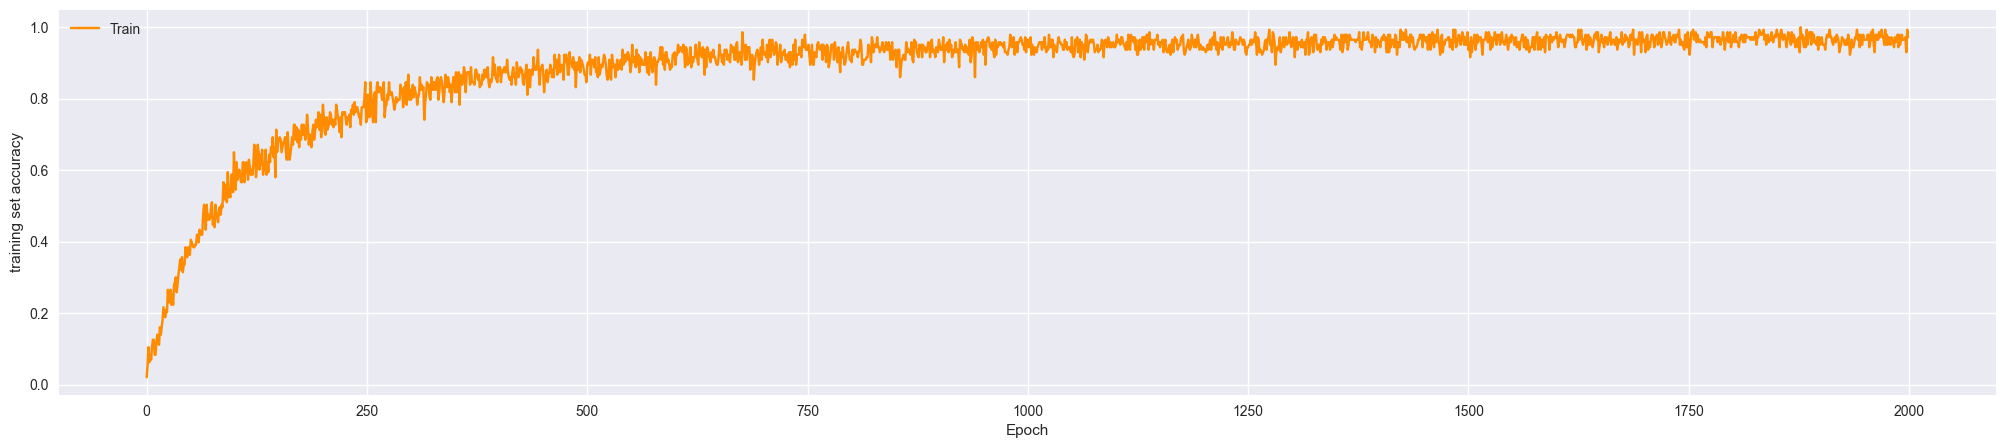

In [24]:
import matplotlib as mp
def draw_plot(data, type_data):
    mp.style.use("seaborn")
    plt.figure(figsize=(25, 5))
    plt.plot(data, "darkorange", label="Train")
    plt.xlabel("Epoch")
    plt.ylabel(type_data)
    plt.legend()

draw_plot(history_training.history["accuracy"], "training set accuracy")

<ipython-input-24-6d4f85c0b90e>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mp.style.use("seaborn")


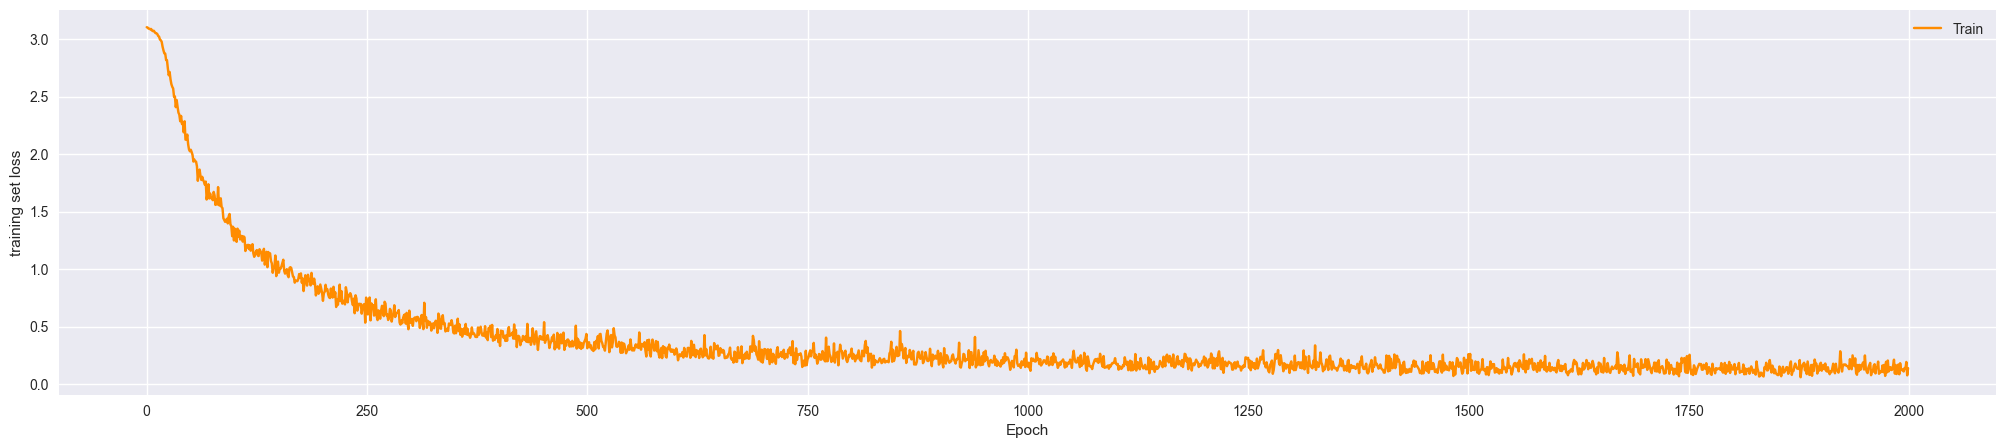

In [25]:
draw_plot(history_training.history['loss'],'training set loss' )

In [26]:
seq.evaluate(features, labels, batch_size=64)

3/3 [==============================] - 1s 6ms/step - loss: 0.0424 - accuracy: 0.9930


[0.04238835722208023, 0.9930070042610168]